In [21]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))


In [22]:
df = pd.read_csv('../data/df_with_features.csv').drop('Unnamed: 0', axis=1)
print(len(df)*0.8)
df.head()

5030.400000000001


,Date,Open,High,Low,Close,Return,Volatility,Cumulated_Return_5d,RSI14,Volume_ROC,ATR,Golden_Cross,Transition
0,2000-01-03 00:00:00-05:00,93.388767,93.388767,90.632775,91.617058,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2000-01-04 00:00:00-05:00,90.416236,90.750892,87.965371,88.034271,-0.039106,NaN,NaN,NaN,NaN,NaN,0,0
2,2000-01-05 00:00:00-05:00,88.152416,89.156385,86.459449,88.191788,0.001789,NaN,NaN,NaN,NaN,NaN,0,0
3,2000-01-06 00:00:00-05:00,87.955523,89.136663,86.774384,86.774384,-0.016072,NaN,NaN,NaN,NaN,NaN,0,0
4,2000-01-07 00:00:00-05:00,88.388651,91.813957,88.231166,91.813957,0.058077,NaN,NaN,NaN,NaN,NaN,0,0


In [23]:
X = df.drop(['Close', 'High', 'Low', 'Open', 'Golden_Cross', 'Transition', 'Date'], axis=1)
y = df['Transition']
X_train = X.iloc[:5030]
X_test = X.iloc[5030:]
y_train = y.iloc[:5030]
y_test = y.iloc[5030:]

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Train positives: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test positives: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Train size: 5030 (80.0%)
Test size: 1258 (20.0%)
Train positives: 593 (11.8%)
Test positives: 120 (9.5%)


Threshold | Precision | Recall | F1
----------------------------------------
0.3      | 0.098     | 0.917  | 0.176
0.4      | 0.094     | 0.850  | 0.170
0.5      | 0.095     | 0.725  | 0.167
0.6      | 0.000     | 0.000  | 0.000
0.7      | N/A (no positive predictions)
0.8      | N/A (no positive predictions)


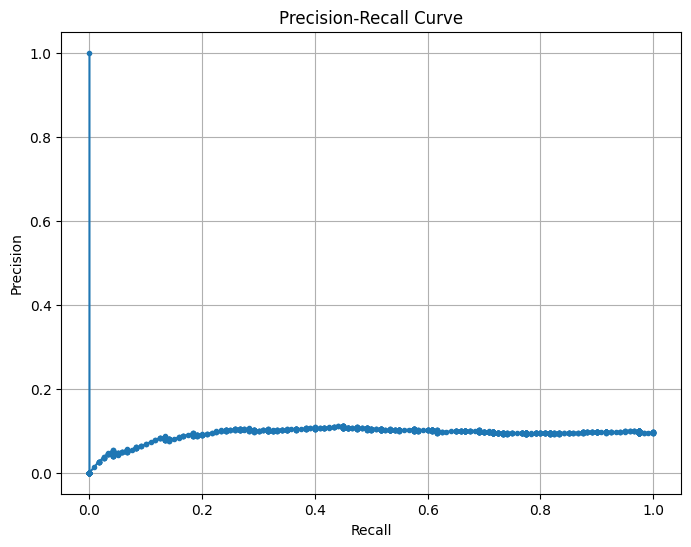

In [27]:
#Baseline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

RFC_base = RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)
RFC_base.fit(X_train, y_train)

y_proba = RFC_base.predict_proba(X_test)[:, 1]

print("Threshold | Precision | Recall | F1")
print("-" * 40)
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    
    if y_pred_thresh.sum() > 0:  # Éviter division par 0
        recall = recall_score(y_test, y_pred_thresh)
        precision = precision_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        
        print(f"{threshold:.1f}      | {precision:.3f}     | {recall:.3f}  | {f1:.3f}")
    else:
        print(f"{threshold:.1f}      | N/A (no positive predictions)")

# Plot Precision-Recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

RFC_base = RandomForestClassifier(max_depth=5)
RFC_base.fit(X_train, y_train)
y_pred = RFC_base.predict(X_test)


## Baseline Model Results

### What We Tested
- **Model**: Random Forest with 6 features (Return, Volatility, Cumulated_Return_5d, RSI14, Volume_ROC, ATR)
- **Target**: Predict transitions 30 days in advance
- **Split**: 80% train (5030 samples) / 20% test (1258 samples)

### Results

| Threshold | Precision | Recall | F1   |
|-----------|-----------|--------|------|
| 0.3       | 0.098     | 0.917  | 0.176|
| 0.4       | 0.095     | 0.850  | 0.170|
| 0.5       | 0.095     | 0.725  | 0.167|

**Verdict**: The model doesn't work. Precision ~0.10 means it's barely better than random guessing (baseline = 9.5%).

### Why Did It Fail?

1. **30-day window too long**: Maybe signals only appear 10-15 days before transitions
2. **Missing key feature**: We removed MA-based features to avoid leakage, but distance to Golden Cross might be crucial
3. **Not enough transitions**: Only ~20 in training set
4. **Maybe transitions are just unpredictable** with technical indicators (valid scientific finding!)

---

## What We'll Try Next

### Add MA Distance Feature
```python
MA_distance = (MA50 - MA200) / MA200
```
**Why it's not leakage**: We use today's MA values to predict future transitions (not using future MA values)


In [46]:
from src.features import add_distances_GC

df1 = df.copy()
df1 = add_distances_GC(df1)
df1.head()

,Date,Open,High,Low,Close,Return,Volatility,Cumulated_Return_5d,RSI14,Volume_ROC,ATR,Golden_Cross,Transition,Distance_GC
0,2000-01-03 00:00:00-05:00,93.388767,93.388767,90.632775,91.617058,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2000-01-04 00:00:00-05:00,90.416236,90.750892,87.965371,88.034271,-0.039106,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,2000-01-05 00:00:00-05:00,88.152416,89.156385,86.459449,88.191788,0.001789,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,2000-01-06 00:00:00-05:00,87.955523,89.136663,86.774384,86.774384,-0.016072,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,2000-01-07 00:00:00-05:00,88.388651,91.813957,88.231166,91.813957,0.058077,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [47]:
X = df1.drop(['Close', 'High', 'Low', 'Open', 'Golden_Cross', 'Transition', 'Date'], axis=1)
y = df1['Transition']
X_train = X.iloc[:5030]
X_test = X.iloc[5030:]
y_train = y.iloc[:5030]
y_test = y.iloc[5030:]

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Train positives: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test positives: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Train size: 5030 (80.0%)
Test size: 1258 (20.0%)
Train positives: 593 (11.8%)
Test positives: 120 (9.5%)


In [48]:
RFC_2 = RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

RFC_2.fit(X_train, y_train)
y_pred = RFC_2.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1: {f1:.2f}')

Recall: 0.53
Precision: 0.31
F1: 0.39


In [49]:
importances = RFC_2.feature_importances_
feature_names = X_train.columns

for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.3f}")

Distance_GC: 0.608
Volatility: 0.218
ATR: 0.056
RSI14: 0.043
Cumulated_Return_5d: 0.036
Volume_ROC: 0.021
Return: 0.018


## Breakthrough: Signal Recovered

### Current Results (with Distance_GC)

**Model**: Random Frest (max_depth=5, class_weight='balanced')

| Metric    | Score |
|-----------|-------|
| Precision | 0.31  |
| Recall    | 0.53  |
| F1        | 0.39  |

**Interpretation**: 
- Precision is **3× better than random baseline** (0.095)
- Results are **stable across different random seeds**
- We have a **real but modest signal**

### Feature Importances

| Feature              | Importance |
|---------------------|------------|
| Distance_GC         | 60.8%      |
| Volatility          | 21.8%      |
| ATR                 | 5.6%       |
| RSI14               | 4.3%       |
| Cumulated_Return_5d | 3.6%       |
| Volume_ROC          | 2.1%       |
| Return              | 1.8%       |

**Key Insight**: Proximity to Golden Cross (60%) and market volatility (22%) are the dominant predictive signals. Traditional momentum indicators contribute minimally.

---

## Next Steps

### Phase 1: Volatility Feature Engineering
**Goal**: Capture volatility dynamics since it's the 2nd most important feature

Test these features individually:
1. **Volatility spike**: `Vol_spike = Volatility / Volatility.rolling(20).mean()`
2. **Volatility acceleration**: `Vol_acceleration = Volatility.diff(10)`
3. **Distance × Volatility interaction**: `Distance_x_Vol = Distance_GC × Volatility`

Compare F1 scores before/after adding each feature.

### Phase 2: Boosting Models
**Goal**: Test if gradient boosting can extract more signal than Random Forest

Models to test:
- **XGBoost** (handles imbalance with `scale_pos_weight`)
- **LightGBM** (faster, sometimes better)

Compare RF vs XGBoost vs LightGBM on same feature set

### Phase 3: Cross-Asset Validation & 7/10 Rule
**Goal**: Verfy generalization and reduce false positives

1. **Cross-asset testing**: Train on SPY, test on DIA/QQQ/IWM
2. **7/10 confirmation rule**: Signal transition only if 7 out of 10 consecutive days predict positive
3. **Final performance assessment**


**Total: ~1 week to complete all experiments**